<a href="https://colab.research.google.com/github/aliash98/BPM_CausalReasoning/blob/main/IDwithMarkovianInput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ylearn

In [ ]:
!pip install networkx==2.8

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
from ylearn.causal_model.graph import CausalGraph
from ylearn.causal_model import CausalModel
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearRegression

In [4]:
def markov_to_semimarkov(G):

  G_sm = nx.DiGraph()

  # Rule 1 ------- Adding all observed nodes to the new graph
  for node in G.nodes(data=True):
    if node[1]['color'] == 'blue':
      G_sm.add_node(node[0])
  
  # Rule 2 ------- Importing edges between two blue nodes
  for edge in G.edges(data=True):
    from_node = edge[0]
    to_node = edge[1]
    from_node_color = G.nodes[from_node]['color']
    to_node_color = G.nodes[to_node]['color']
    if from_node_color =='blue' and to_node_color =='blue':
      G_sm.add_edge(edge[0], edge[1])

  # Rule 3 ------- Adding edges for directed paths through grey nodes between two blue nodes
  grey_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'grey']  
  blue_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'blue']

  for source in blue_nodes:
    for sink in blue_nodes:
      if source == sink or G.has_edge(source, sink):
        continue
      for path in nx.all_simple_paths(G, source=source, target=sink):
        counter = 0
        for between_node in path:
          if between_node in blue_nodes:
            counter += 1
        if counter == 2:
          G_sm.add_edge(source, sink)
          break
    
  # Rule 4 ------- Extracting the hidden confounders
  confounding_list = []

  for source in grey_nodes:
    potential_confounding = []
    for sink in blue_nodes:
      for path in nx.all_simple_paths(G, source=source, target=sink):
        red_flag = 0
        for between_node in path:
          if between_node in blue_nodes and between_node != sink:
            red_flag = 1
            break
        if red_flag == 0:
          potential_confounding.append(sink)
          break
    if len(potential_confounding) > 1:
      confounding_list.append(potential_confounding)
    
  # we construct a graph for confounding arcs
  G_confounded = nx.Graph()
  for item in confounding_list:
    for i in range(len(item)):
        for j in range(i + 1 , len(item)):
          G_confounded.add_edge(item[i], item[j])
  # nx.draw(G_confounded, with_labels=True, font_weight='bold', node_size=500)

  return G_sm, list(G_confounded.edges())

[('V2', 'V1')]
['V3']


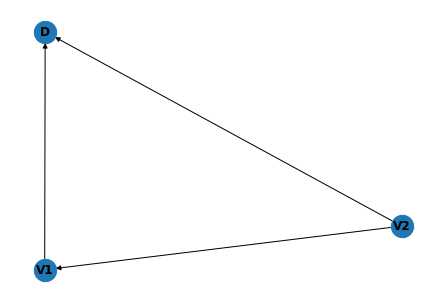

In [35]:
# Creating a graph

G = nx.DiGraph()
G.add_nodes_from([
    ('V3', {"color": "grey"}),
    ('V2', {"color": "blue"}),
    ('V1', {"color": "blue"}),
    ('D', {"color": "blue"}),
])
G.add_edge('V3', 'V2')
G.add_edge('V3', 'V1')
G.add_edge('V2', 'V1')
G.add_edge('V2', 'D')
G.add_edge('V1', 'D')

grey_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'grey']

final_graph, confounded_vars = markov_to_semimarkov(G)
nx.draw(final_graph, with_labels=True, font_weight='bold', node_size=500)
print(confounded_vars)
print(grey_nodes)

In [21]:
# Feeding it to ID algrotihm

causation = nx.to_dict_of_lists(final_graph.reverse(copy=True))

# causation = {
#         'V2': [],
#         'V1': ['V2'],
#         'D': ['V1', 'V2'],
# }

# Here we define that V1 and V2 are connected with a hidden confounder (V3)
arcs = confounded_vars
# arcs = [('V1', 'V2')]

cg = CausalGraph(causation, latent_confounding_arcs=arcs)
# cg = CausalGraph(causation)
cm = CausalModel(cg)

try:
  p = cm.id({'D'}, {'V1'})
except:
  print("The query is not identifiable")
else:
  print("The query is identifiable")
  p.show_latex_expression()

# TODO: show latex doesn't work after print

The query is identifiable


In [9]:
nx.to_dict_of_lists(final_graph.reverse(copy=True))

{'V2': [], 'V1': ['V2'], 'D': ['V2', 'V1']}

In [29]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1)))

output = powerset(['V1', 'V2'])
print(list(output))

[('V1',), ('V2',), ('V1', 'V2')]


In [ ]:
# Let's convert it to a function


# INPUT: Markovian graph (including observed(blue)/unobserved(grey)), Targer node, Intervention node
def ID_with_markov(G, T, I):
  grey_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'grey']

  final_graph, confounded_vars = markov_to_semimarkov(G)

  causation = nx.to_dict_of_lists(final_graph.reverse(copy=True))
  arcs = confounded_vars

  cg = CausalGraph(causation, latent_confounding_arcs=arcs)
  cm = CausalModel(cg)
  try:
    p = cm.id({'D'}, {'V1'})
  except:
    power_set = powerset(grey_nodes)
    print(power_set)
    for grey_set in power_set:
      grey_list = grey_set
      # turn the graph into a new one
      for grey_node in grey_set:
        nx.set_node_attributes(G, {0: "red", 1: "blue"}, name="color")

        # ...
    return False
    # print("The query is not identifiable")
  else:
    return True
    # print("The query is identifiable")
    # p.show_latex_expression()

